# Parallel Tempering

In [9]:
using Distributions, StatsBase, StatsPlots
using Plots
using LaTeXStrings
pyplot()

Plots.PyPlotBackend()

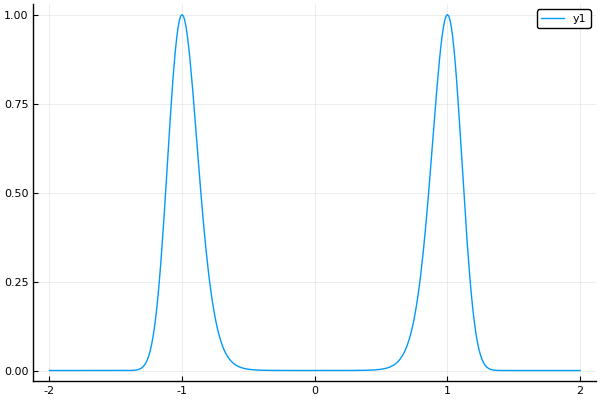

In [10]:
target_dist(x) = exp(-10*(x^2 - 1)^2)
plot((-2:0.01:2),target_dist.(-2:0.01:2))

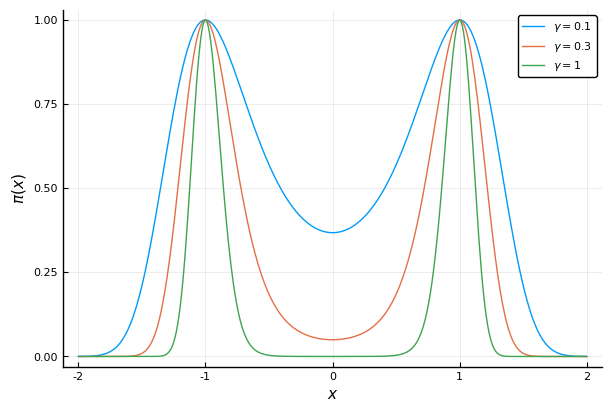

In [13]:
function target_temp(k,x)
    γ = collect(0.1:0.1:1);
    y = target_dist(x)^γ[k]
    return y
end
plot((-2:0.01:2),target_temp.(1,-2:0.01:2),label=L"\gamma=0.1")
plot!((-2:0.01:2),target_temp.(3,-2:0.01:2),label=L"\gamma=0.3")
p = plot!((-2:0.01:2),target_temp.(10,-2:0.01:2),label=L"\gamma=1",xlabel=L"x",ylabel=L"\pi(x)")
savefig(p, "./images/Tempered.png")

### Running Metropolis-Hastings for the tempered targets

In [22]:
N  = 10_000
ss = .5
K  = 10
X  = zeros(N,K)
C  = zeros(N,K)
X[1]  = randn()
for k = 1:10
    for i = 1:N-1
        Xnew = rand(Normal(X[i,k],ss))
        alpha = minimum([1, exp(log(target_temp(k,Xnew)) - log(target_temp(k,X[i,k])))])
        if rand() < alpha
            X[i+1,k] = Xnew
            C[i+1,k] = Xnew
        else
            X[i+1,k] = X[i,k]
        end
    end
end
    

Looking at the trace plot, for the distributions with higher $\gamma$ we don't get a very good mixture. This problem is not
present when $\gamma$ is lower.

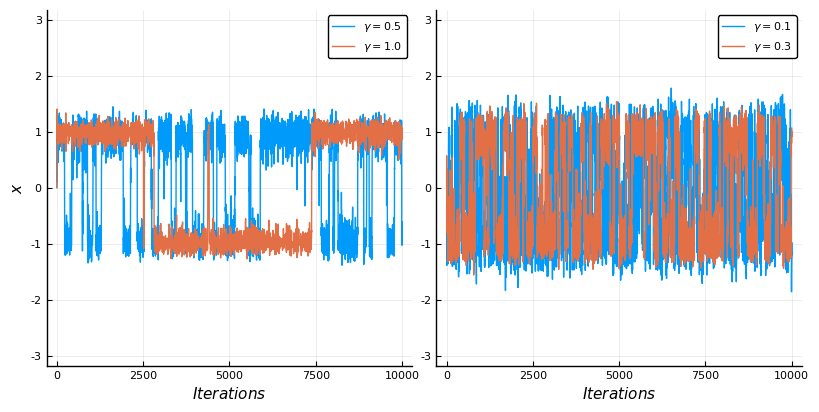

In [23]:
plot(X[:,5],label=L"\gamma = 0.5")
p1 = plot!(X[:,10],label=L"\gamma = 1.0",xlabel=L"Iterations",ylabel=L"x")
plot(X[:,1],label=L"\gamma = 0.1")
p2 = plot!(X[:,3],label=L"\gamma = 0.3", xlabel=L"Iterations")
p3 = plot(p1,p2,layout=2,ylims=[-3,3],size=(800,400))
savefig(p3,"./images/Trace1.png")

In [24]:
N  = 10_000
ss = .5
K  = 10
X  = zeros(N,K)
C  = zeros(N,K)
γ = collect(0.1:0.1:1)
X[1,:]  = randn(K)
for i = 1:N-1
    Xnew = rand(MvNormal(X[i,:],ss))
    alpha = exp.(log.(target_dist.(Xnew).^γ) .- log.(target_dist.(X[i,:]).^γ))
    acc   = rand(K) .< alpha 
    X[i+1,:] = acc .*Xnew .+ (1 .- acc).*X[i,:]
    k,l = rand(1:K,2)
    change_p = log(target_dist(X[i+1,l])^γ[k])+log(target_dist(X[i+1,k])^γ[l]) - log(target_dist(X[i+1,k])^γ[k]) - log(target_dist(X[i+1,l])^γ[l])
    if log(rand()) < change_p
        change_k = X[i+1,k]
        change_l = X[i+1,l]
        X[i+1,k] = change_l
        X[i+1,l] = change_k
    end
end

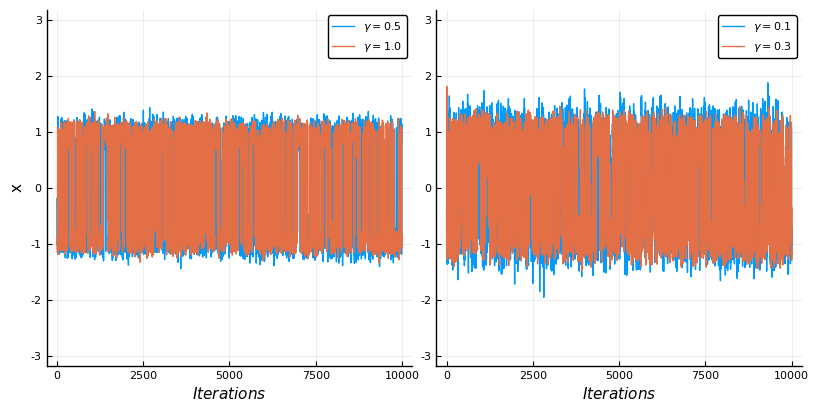

In [25]:
plot(X[:,5],label=L"\gamma = 0.5")
p1 = plot!(X[:,10],label=L"\gamma = 1.0",xlabel=L"Iterations",ylabel="x")
plot(X[:,1],label=L"\gamma = 0.1")
p2 = plot!(X[:,3],label=L"\gamma = 0.3",xlabel=L"Iterations")
p3 = plot(p1,p2,layout=2,ylims=[-3,3],size=(800,400))
savefig(p3, "./images/Trace2.png")